In [1]:
from tqdm.notebook import tqdm

import jax
from jax import numpy as jnp
import optax

from dart import dataset, VirtualRadar, fields, DART

In [2]:
sensor = VirtualRadar.from_config("data/sim_96.json", n=256, k=128)

gt = dataset.gt_map("data/map.mat")
ds = dataset.dart("data/traj.mat", "data/sim_96.npz", sensor, pre_shuffle=True)
ds = ds.shuffle(100000, reshuffle_each_iteration=True)

In [3]:
# optimizer = optax.adamw(optax.exponential_decay(
#     0.01, 500, 0.01, transition_begin=100, end_value=0.001))
optimizer = optax.adam(0.01)

def sigma():
    return fields.NGP(
        levels=4 * 2**(0.5 * jnp.arange(8)),
        size=(65536, 2))
dart = DART(sensor, optimizer, sigma)
state = dart.init(jax.random.PRNGKey(42), ds.batch(2))

In [4]:
state = dart.fit(
    jax.random.PRNGKey(42), ds.batch(2048), state, epochs=1, tqdm=tqdm)

Epoch 0:   0%|          | 0/441 [00:00<?, ?batch/s]

2023-01-13 11:56:46.389317: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  dynamic-slice.25 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-01-13 11:56:46.887093: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 1.49789526s
Constant folding an instruction is taking > 1s:

  dynamic-slice.25 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).


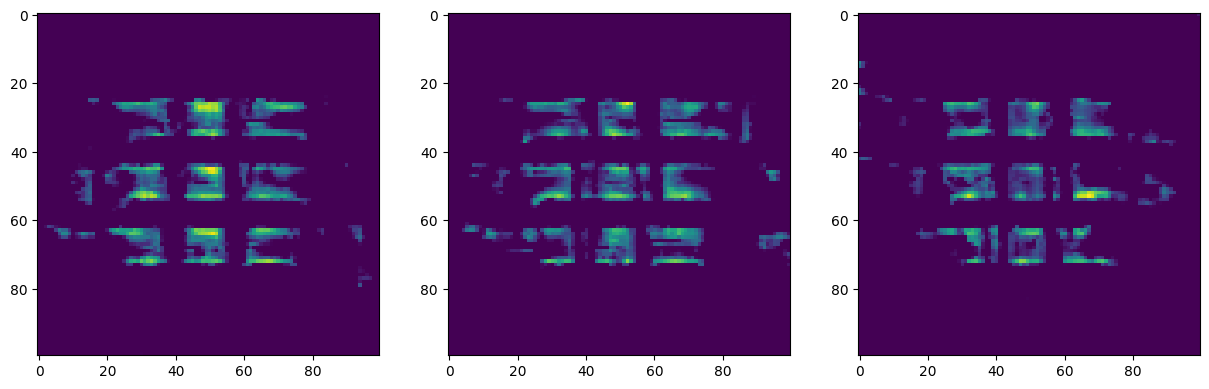

In [6]:
from jax import numpy as jnp
from matplotlib import pyplot as plt

x = jnp.linspace(-5, 5, 100)
grid = dart.grid(state.params, x, x, x)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for layer, ax in zip([30, 50, 70], axs):
    ax.imshow(grid[:, layer, :, 0])

In [9]:
from jax import numpy as jnp

traj = dataset.image_traj("data/traj.mat", "data/sim_96.npz")
poses, images = list(traj.shuffle(10000).batch(8).take(1))[0]
poses_jnp = jax.tree_util.tree_map(jnp.array, poses)
predicted = dart.render(state, poses_jnp, key=42)

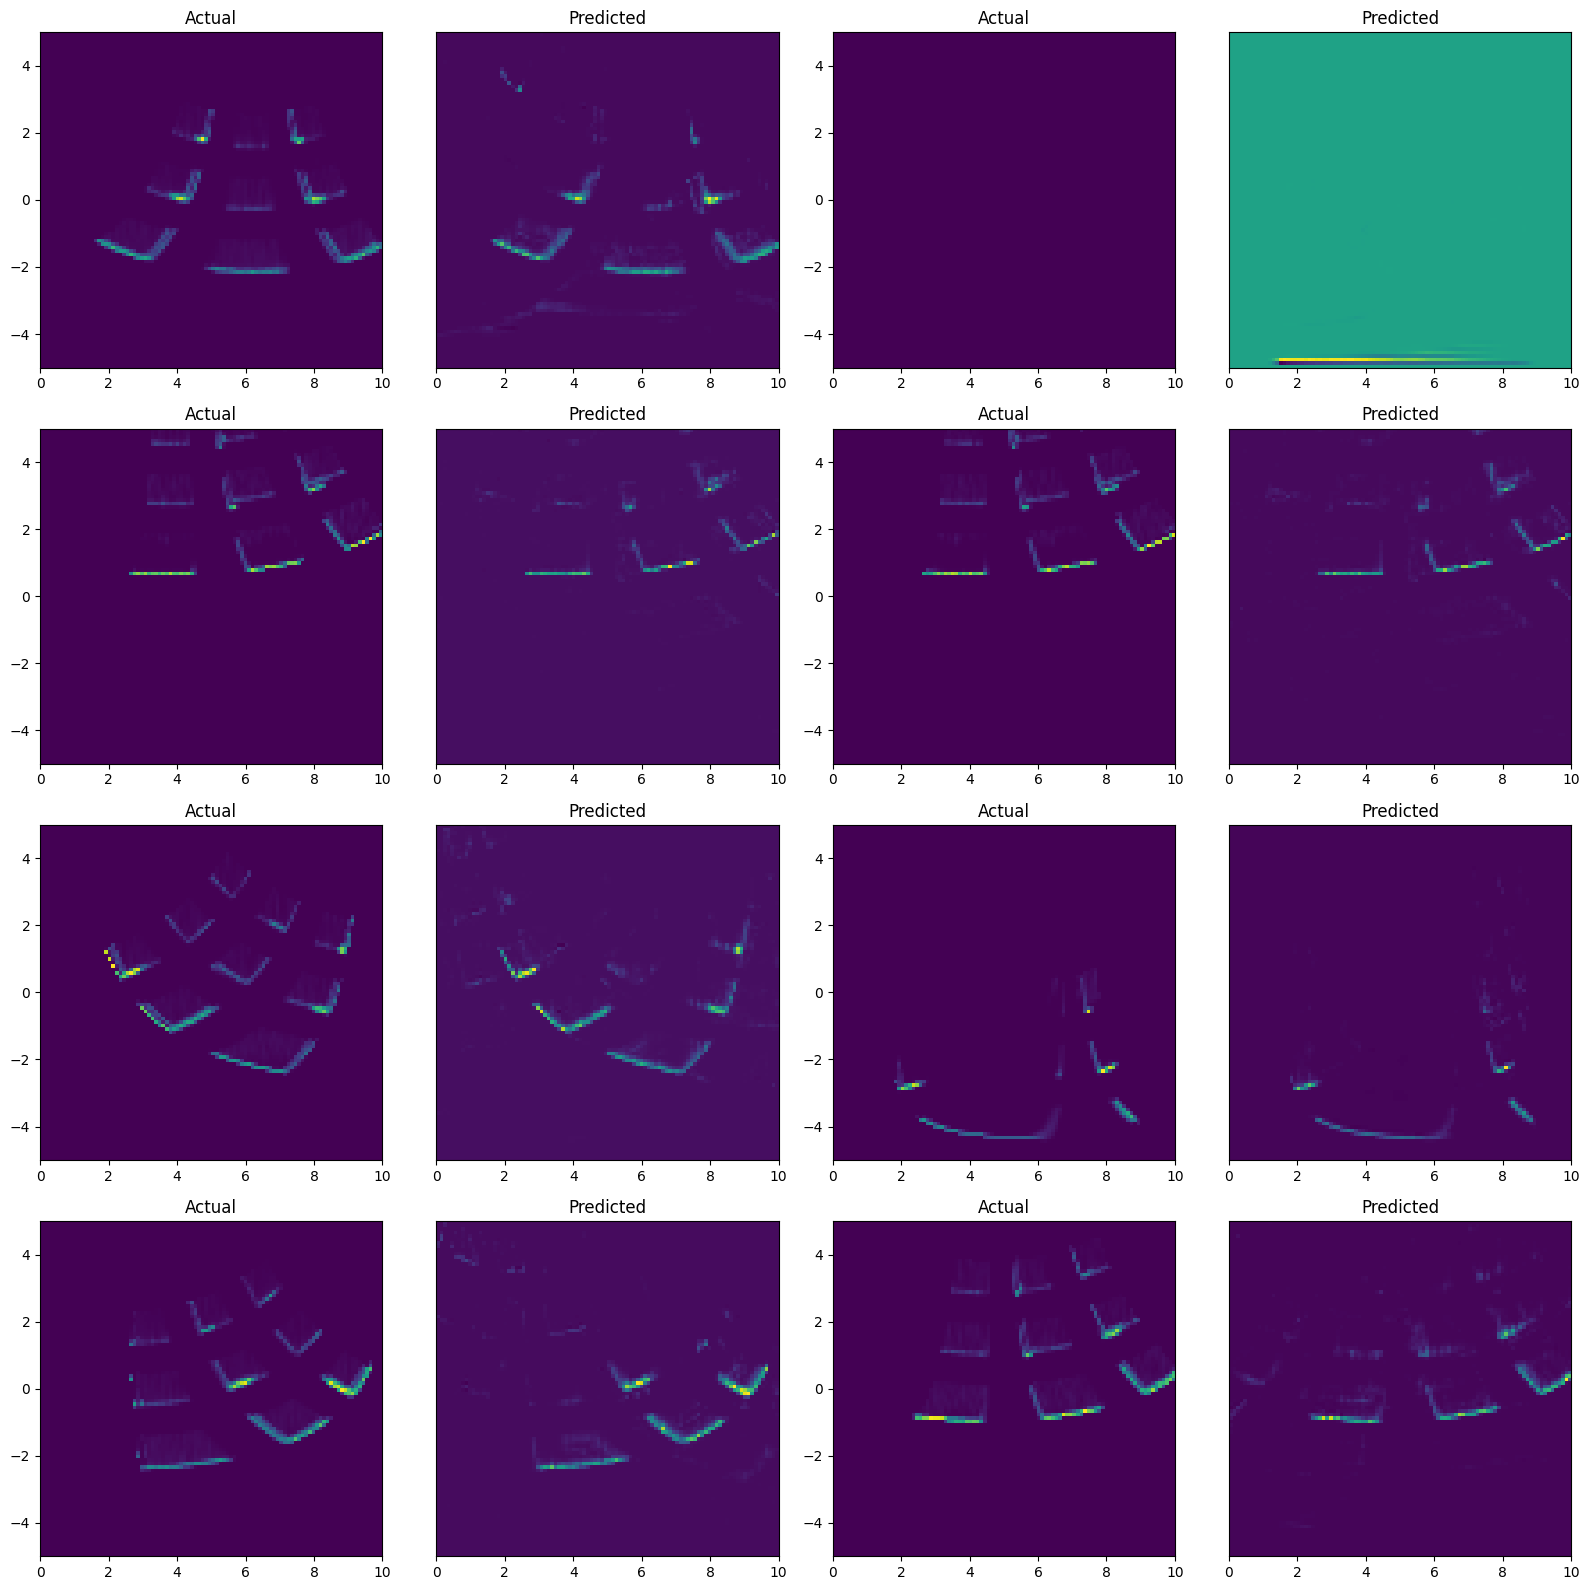

In [10]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for y_true, y_pred, pair in zip(images, predicted, axs.reshape(-1, 2)):
    sensor.plot_image(pair[0], y_true)
    sensor.plot_image(pair[1], y_pred)
    pair[0].set_title("Actual")
    pair[1].set_title("Predicted")
    pair[1].set_yticks([])

fig.tight_layout()